## Topic: Analysis of the contributing factors and prediction of the outcome of a chess game ### 

Dataset: https://www.kaggle.com/datasets/maca11/chess-games-from-lichess-20132014

Description:
This dataset contains data from all rated games played in Lichess from January 2013 to December 2014, in total there are around 15.000.000 games. It includes names of the players, ratings, winner, opening, number of moves, etc.



**Objective:** 
Our goal in this project is to study the factors that affect the chance of winning in a chess game. The dependent variable is the “Winner” and we consider possible contributing factors such as the Elo of the players, number of moves, etc. We also investigate the correlation that might exist between the independent variables.

**Hypothesis to test : **

*Hypothesis 1*: White Player has a greater chance of winning than the Black player. (Raghu)

*Hypothesis 2*: The greater the difference in ratings of two players, the higher the probability of the higher-rated player to win. (Atie)

Hypothesis 3: For games in the Ultrabullet (Less than 29 seconds)  and bullet (Less than the 179 seconds) categories, the white player is more likely to win. (Mantaj)

**Predictive Model:**

Predict the outcome of a game based on the information we have about the two players and other attributes of the game? (Arvind)


**Features of the Dataset:**

**WhiteElo**: Elo of the player with white pieces which shows their level of 
proficiency

**BlackElo**: Elo of the player with black pieces which shows their level of proficiency

WhiteName: Name of the player with white pieces

BlackName: Name of the player with black pieces

**Winner**: Color of the winning pieces. If the game ended in Draw it shows it.

**Termination**: How the game ended, it can be: Normal, Time Forfeit, Abandon or Rules infraction.
- Normal: When the game end in checkmate, abandon or draw
- Time Forfeit: When one of the players runs out of time
- Abandon: When in a competition one of the players doesn't make a move
- Rules infraction: When one of the players is banned

Site: URL of the game

Day: Day when the game was played

Month: Month when the game was played

Year: Year when the game was played

**InitialTime**: Time each player has before starting the game in seconds

**Increment**: Increment in the time after each player makes a move in seconds

**TimeControl**: Classification of the games based on the estimated duration of a game calculated as InitialTime+ 40*Increment. If estimated duration:
- <=29s: Ultrabullet
- <=179s: Bullet
- <=479s: Blitz
- <=1499s: Rapid
- Bigger or equal than 1500s: Classical

**Opening**: Opening Name

**ECO**: Classification of the games based on the ECO(Encyclopaedia of Chess Openings ) code

**Number of Moves**: Number of moves of the game

FEN: FEN of the game

# Import Libraries and Data Setup #

In [4]:
# Import libraries
import numpy as np  
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.ticker as ticker

import datetime

import seaborn as sns
sns.set_theme(context='paper', style='whitegrid', palette="deep", font='sans-serif', font_scale=1, color_codes=True, rc=None)

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

import scipy
from scipy import stats
from scipy.stats import norm
from scipy.special import logit

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



In [5]:
#Install PyDrive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# Getting the file_id 

filedownloaded = drive.CreateFile({'id':'1-5dKb8PXKf9aCsjyBCg2S_-7t2A9GQX7'})

In [8]:
# Load the csv
filedownloaded.GetContentFile('Lichess_2013_wl_df_export_Final.csv')

In [9]:
# Load the 2013 Lichess Dataset into the df_fnl Dataframe

df_fnl = pd.read_csv('Lichess_2013_wl_df_export_Final.csv', sep=',')

In [10]:
df_fnl.head(5)

,Unnamed: 0,WhiteElo,BlackElo,Winner,Termination,Day,Month,Year,InitialTime,Increment,TimeControl,Number_of_Moves
0,134,1516,1480,White,Time forfeit,1,1,2013,60,0,Bullet,28
1,135,1231,1814,Black,Normal,1,1,2013,60,0,Bullet,19
2,136,1612,1555,Black,Normal,1,1,2013,60,1,Bullet,13
3,137,1879,1237,White,Time forfeit,1,1,2013,60,0,Bullet,21
4,138,1815,1222,White,Time forfeit,1,1,2013,60,0,Bullet,33


In [11]:
df_fnl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269322 entries, 0 to 3269321
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Unnamed: 0       int64 
 1   WhiteElo         int64 
 2   BlackElo         int64 
 3   Winner           object
 4   Termination      object
 5   Day              int64 
 6   Month            int64 
 7   Year             int64 
 8   InitialTime      int64 
 9   Increment        int64 
 10  TimeControl      object
 11  Number_of_Moves  int64 
dtypes: int64(9), object(3)
memory usage: 299.3+ MB


In [12]:
df_fnl.nunique()

Unnamed: 0         3269322
WhiteElo              1748
BlackElo              1766
Winner                   2
Termination              3
Day                     31
Month                   12
Year                     1
InitialTime             39
Increment               40
TimeControl              4
Number_of_Moves        158
dtype: int64

# Exploratory Data Analysis #

In [13]:
# Defining case_when Function

def case_when(*args):
    return np.select(
        condlist = [args[i] for i in range(0, len(args), 2)],
        choicelist = [args[i] for i in range(1, len(args), 2)],
        default=pd.NA
    )

In [14]:
# Coding numbers against the 2 categorical variables White - 1 and Black as 0
df_fnl['Win_Color'] = case_when(df_fnl['Winner'] == "White", 1,
                              df_fnl['Winner'] == "Black", 0 
                              )

In [15]:
# Creating a new feature - "Rating" that pseudo codes the color that has the higher rating among the 2 players

df_fnl['Rating'] = case_when(df_fnl['WhiteElo'] == df_fnl['BlackElo'], "EQ" ,
                                  df_fnl['WhiteElo'] > df_fnl['BlackElo'], "W" ,
                                  df_fnl['WhiteElo'] < df_fnl['BlackElo'], "B" 
                                 )

In [16]:
df_fnl['Rating'].value_counts()

W     1695100
B     1564554
EQ       9668
Name: Rating, dtype: int64

In [17]:
# Performing One Hot Encoding on TimeControl, Termination and Rating columns

dummy_time= pd.get_dummies(df_fnl['TimeControl'], prefix ='TimeControl')
dummy_term = pd.get_dummies(df_fnl['Termination'], prefix ='Term')
dummy_rating = pd.get_dummies(df_fnl['Rating'], prefix ='Rating')

In [18]:
dummy_time.head(5)

,TimeControl_Blitz,TimeControl_Bullet,TimeControl_Classical,TimeControl_Rapid
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [19]:
dummy_term.head(5)

,Term_Normal,Term_Rules infraction,Term_Time forfeit
0,0,0,1
1,1,0,0
2,1,0,0
3,0,0,1
4,0,0,1


In [20]:
dummy_rating.head(5)

,Rating_B,Rating_EQ,Rating_W
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [21]:
# Joining the encoded columns to the main data frame

df_fnl = df_fnl.join(dummy_time)
df_fnl = df_fnl.join(dummy_term)
df_fnl = df_fnl.join(dummy_rating)

In [22]:
# Calculate Difference in Rating Attribute

df_fnl['Diff_Rating'] = abs(df_fnl['WhiteElo'] - df_fnl['BlackElo'])

In [23]:
# Compute 1 0r 0 based on whethter a High_Rated_Player wins ; 1 - When the Player who has the highest rating among the 2, also wins, 0 otherwise

df_fnl['Higher_Rated_Plyr_Win'] = case_when((df_fnl['Rating'] == 'W') & (df_fnl['Winner'] == 'White'), 1 ,
                                    (df_fnl['Rating'] == 'B') & (df_fnl['Winner'] == 'Black'), 1 ,
                                    (df_fnl['Rating'] == 'W') & (df_fnl['Winner'] == 'Black'), 0 ,
                                    (df_fnl['Rating'] == 'B') & (df_fnl['Winner'] == 'White'), 0 ,
                                    (df_fnl['Rating'] == 'EQ') & (df_fnl['Winner'] == 'White'), 2 ,
                                    (df_fnl['Rating'] == 'EQ') & (df_fnl['Winner'] == 'Black'), 3 
                                   )

In [24]:
df_fnl['Higher_Rated_Plyr_Win'].value_counts()

1    2155105
0    1104549
2       5188
3       4480
Name: Higher_Rated_Plyr_Win, dtype: int64

In [25]:
df_fnl.dtypes

Unnamed: 0                int64
WhiteElo                  int64
BlackElo                  int64
Winner                   object
Termination              object
Day                       int64
Month                     int64
Year                      int64
InitialTime               int64
Increment                 int64
TimeControl              object
Number_of_Moves           int64
Win_Color                object
Rating                   object
TimeControl_Blitz         uint8
TimeControl_Bullet        uint8
TimeControl_Classical     uint8
TimeControl_Rapid         uint8
Term_Normal               uint8
Term_Rules infraction     uint8
Term_Time forfeit         uint8
Rating_B                  uint8
Rating_EQ                 uint8
Rating_W                  uint8
Diff_Rating               int64
Higher_Rated_Plyr_Win    object
dtype: object

In [26]:
df_fnl.head(5)

,Unnamed: 0,WhiteElo,BlackElo,Winner,Termination,Day,Month,Year,InitialTime,Increment,...,TimeControl_Classical,TimeControl_Rapid,Term_Normal,Term_Rules infraction,Term_Time forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,134,1516,1480,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,36,1
1,135,1231,1814,Black,Normal,1,1,2013,60,0,...,0,0,1,0,0,1,0,0,583,1
2,136,1612,1555,Black,Normal,1,1,2013,60,1,...,0,0,1,0,0,0,0,1,57,0
3,137,1879,1237,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,642,1
4,138,1815,1222,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,593,1


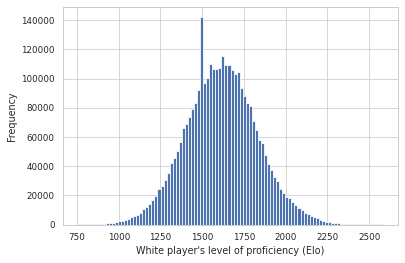

In [27]:
# Plot the White player's level of proficiency (Elo) Attribute
plt.hist(df_fnl["WhiteElo"], bins=100)
plt.xlabel("White player's level of proficiency (Elo)")
plt.ylabel("Frequency")
plt.show()

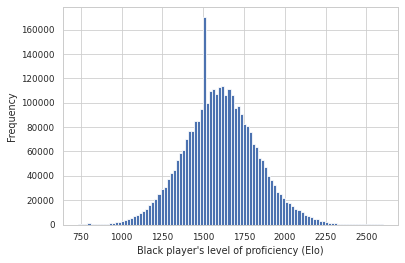

In [28]:
# Plot the Black player's level of proficiency (Elo) Attribute
plt.hist(df_fnl["BlackElo"], bins=100)
plt.xlabel("Black player's level of proficiency (Elo)")
plt.ylabel("Frequency")
plt.show()

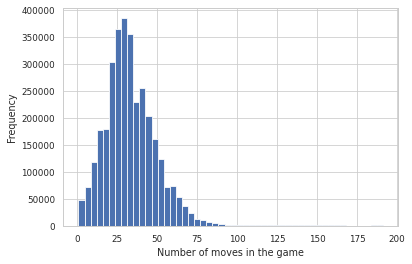

In [29]:
# Plot the Number of Moves Attribute
plt.hist(df_fnl["Number_of_Moves"], bins=50)
plt.xlabel("Number of moves in the game")
plt.ylabel("Frequency")
plt.show()

Based on the above table on InitialTime, a time of 0 minutes doesn't make a lot of sense. Therefore dropping those records to get a more cleaner dataset for the prediction model

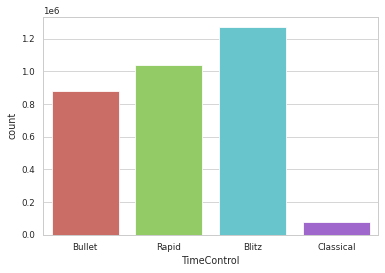

In [30]:
# Plot the TimeControl Attribute

sns.countplot(x='TimeControl', data=df_fnl, palette='hls')
plt.show()

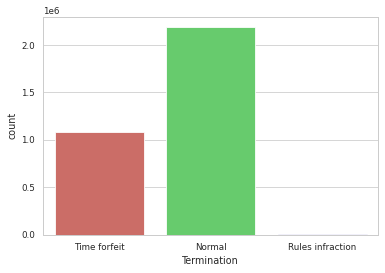

In [31]:
# Plot the Termination Attribute

sns.countplot(x='Termination', data=df_fnl, palette='hls')
plt.show()

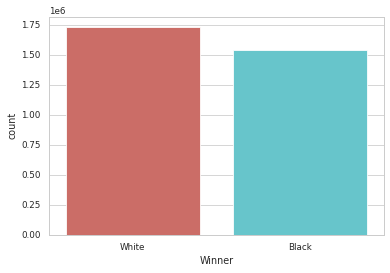

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot the Winner Attribute

sns.countplot(x='Winner', data=df_fnl, palette='hls')
plt.show()
plt.savefig('Count Plot')

In [33]:
df_fnl.head(5)

,Unnamed: 0,WhiteElo,BlackElo,Winner,Termination,Day,Month,Year,InitialTime,Increment,...,TimeControl_Classical,TimeControl_Rapid,Term_Normal,Term_Rules infraction,Term_Time forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,134,1516,1480,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,36,1
1,135,1231,1814,Black,Normal,1,1,2013,60,0,...,0,0,1,0,0,1,0,0,583,1
2,136,1612,1555,Black,Normal,1,1,2013,60,1,...,0,0,1,0,0,0,0,1,57,0
3,137,1879,1237,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,642,1
4,138,1815,1222,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,593,1


In [34]:
df_fnl['Winner'].value_counts()

White    1726917
Black    1542405
Name: Winner, dtype: int64

From the above chart, we can infer that both White and Black Winners have equal representation and therefore, it is an not an unbalanced data set

As the TimeControl attribute is a derived attribute of Initial Time and Increment, we can remove those fields from the list of predictor variables

In [35]:
# Renaming Columns

df_fnl.rename(columns={'Term_Rules infraction': 'Term_Rul_Infraction', 'Term_Time forfeit': 'Term_Rul_Time_Forfeit', 'Term_Normal': 'Term_Rul_Normal'}, inplace=True)
df_fnl.head()

,Unnamed: 0,WhiteElo,BlackElo,Winner,Termination,Day,Month,Year,InitialTime,Increment,...,TimeControl_Classical,TimeControl_Rapid,Term_Rul_Normal,Term_Rul_Infraction,Term_Rul_Time_Forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,134,1516,1480,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,36,1
1,135,1231,1814,Black,Normal,1,1,2013,60,0,...,0,0,1,0,0,1,0,0,583,1
2,136,1612,1555,Black,Normal,1,1,2013,60,1,...,0,0,1,0,0,0,0,1,57,0
3,137,1879,1237,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,642,1
4,138,1815,1222,White,Time forfeit,1,1,2013,60,0,...,0,0,0,0,1,0,0,1,593,1


In [36]:
# Dropping Unnamed :0, IntitialTime, Increment, Day, Month, Year columns from the dataframe

df_fnl = df_fnl.drop(['Day', 'Month', 'Year', 'InitialTime', 'Increment', 'Unnamed: 0'], axis=1)

In [37]:
df_fnl.dtypes

WhiteElo                  int64
BlackElo                  int64
Winner                   object
Termination              object
TimeControl              object
Number_of_Moves           int64
Win_Color                object
Rating                   object
TimeControl_Blitz         uint8
TimeControl_Bullet        uint8
TimeControl_Classical     uint8
TimeControl_Rapid         uint8
Term_Rul_Normal           uint8
Term_Rul_Infraction       uint8
Term_Rul_Time_Forfeit     uint8
Rating_B                  uint8
Rating_EQ                 uint8
Rating_W                  uint8
Diff_Rating               int64
Higher_Rated_Plyr_Win    object
dtype: object

In [38]:
df_fnl.head(10)

,WhiteElo,BlackElo,Winner,Termination,TimeControl,Number_of_Moves,Win_Color,Rating,TimeControl_Blitz,TimeControl_Bullet,TimeControl_Classical,TimeControl_Rapid,Term_Rul_Normal,Term_Rul_Infraction,Term_Rul_Time_Forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,1516,1480,White,Time forfeit,Bullet,28,1,W,0,1,0,0,0,0,1,0,0,1,36,1
1,1231,1814,Black,Normal,Bullet,19,0,B,0,1,0,0,1,0,0,1,0,0,583,1
2,1612,1555,Black,Normal,Bullet,13,0,W,0,1,0,0,1,0,0,0,0,1,57,0
3,1879,1237,White,Time forfeit,Bullet,21,1,W,0,1,0,0,0,0,1,0,0,1,642,1
4,1815,1222,White,Time forfeit,Bullet,33,1,W,0,1,0,0,0,0,1,0,0,1,593,1
5,1877,1319,White,Normal,Bullet,20,1,W,0,1,0,0,1,0,0,0,0,1,558,1
6,1367,1555,Black,Time forfeit,Bullet,10,0,B,0,1,0,0,0,0,1,1,0,0,188,1
7,1507,1617,White,Normal,Rapid,31,1,B,0,0,0,1,1,0,0,1,0,0,110,0
8,1542,1404,White,Normal,Rapid,80,1,W,0,0,0,1,1,0,0,0,0,1,138,1
9,1540,1653,White,Normal,Blitz,29,1,B,1,0,0,0,1,0,0,1,0,0,113,0


# Hypothesis 1

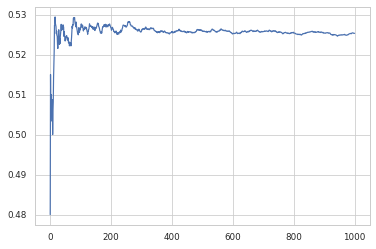

In [39]:
#Lets do a random sampling of the existing data to see how well the hypothesis fits in the existing data. 
#The hypothesis to test here is that white player has a higher probability to win than black player.

samplesize = 100
whitewin = 0
x_data = []
y_data = []

for num_simulations in range(1, 1001):
    df_sample = df_fnl.sample(n=samplesize)
    whitewin += len(df_sample[df_sample.Win_Color == 1])
    y_data.append(float(whitewin) / float(num_simulations*samplesize))
    x_data.append(num_simulations)

plt.plot(x_data,y_data)
#Based on the plot below the plot, the probability of white winning any game is about 0.53. Though this is slightly higher than
#the ideal mean of 0.5, this is not strong enough to indicate a bias towards white for any game. 

In [40]:
#Lets start will a null hypothesis that probability of white winning is 0.50.

#samplesize = len(df_sample.index)
#whitewin = len(df_sample[df_sample.Win_Color == 1])
#pointestimate = whitewin/samplesize
pointestimate = y_data[num_simulations-1]
print ("pointestimate:", pointestimate)
#p for null hypothesis
po = 0.5
#standard error for null hypothesis
SEo = np.sqrt(((po*(1-po))/samplesize))
print ("Standard Error:", SEo)

sigma = SEo * np.sqrt(samplesize)
print ("Sigma:", sigma)

z = (pointestimate - po)/SEo
print ("Z Value:", z)

pnew = 2*norm.sf(abs(z))

print ("New P-value", pnew)

pointestimate: 0.52532
Standard Error: 0.05
Sigma: 0.5
Z Value: 0.5064000000000002
New P-value 0.6125758745724573


In [41]:
if pnew <= 0.05:
    print("The new p-value is less than 0.05 and hence the NULL hypothesis can be rejected with 95% confidence. The probability of winning is not equal for both white and black")
else:
    print("The new p-value is greater than 0.05 and hence the NULL hypothesis cannot be rejected. There is no strong evidence to reject that winning is equal for both white and black")

The new p-value is greater than 0.05 and hence the NULL hypothesis cannot be rejected. There is no strong evidence to reject that winning is equal for both white and black


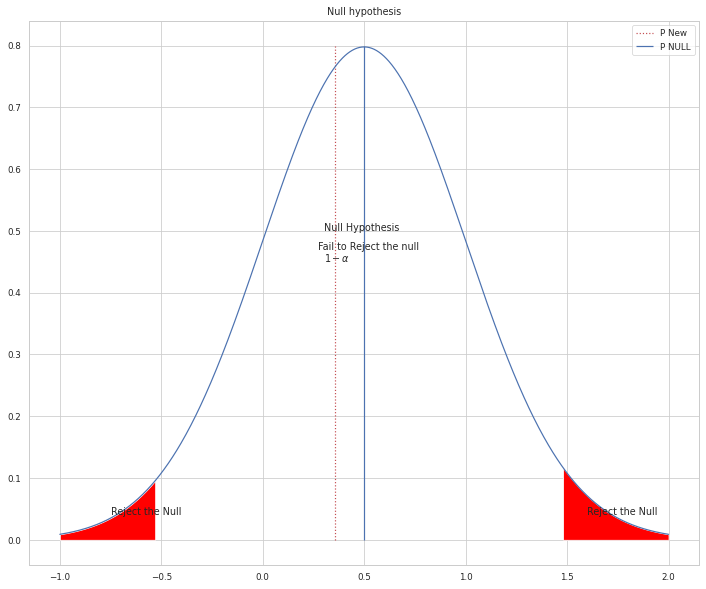

In [42]:
plt.figure(figsize=(12,10))

#find the value where the 95% confidence level starts
x_cr = norm.ppf(0.025, loc=po, scale=sigma)
x_r = (po - x_cr) + po

start = po-3*(sigma)
end = po+3*(sigma)
if po < pointestimate:
    pnew = 1 - pnew
    
x = np.linspace(start, end, 1000)
plt.plot(x, norm.pdf(x, loc=po, scale=sigma))
plt.title("Null hypothesis")
plt.fill_between(x=np.arange(start, (start + abs(x_cr)), 0.01), y1=norm.pdf(np.arange(start, (start + abs(x_cr)), 0.01), loc=po, scale=sigma),
                 facecolor='red')
plt.fill_between(x=np.arange(x_r,end, 0.01), y1= norm.pdf(np.arange(x_r, end,0.01), loc=po, scale=sigma) ,
                 facecolor='red')

plt.text(x=0.30, y=0.5, s= "Null Hypothesis")
plt.text(x=0.27, y=0.47, s= 'Fail to Reject the null')
plt.text(x=0.30, y=0.45, s=r'$1- \alpha$')
plt.text(x=-0.75, y=0.04, s= "Reject the Null")
plt.text(x=1.6, y=0.04, s= "Reject the Null")

plt.vlines(norm.ppf(pnew, loc=po, scale=sigma), 0, 0.8, colors='r', linestyles='dotted', label='P New')
plt.vlines(po, 0, 0.8, colors='b', linestyles='solid', label='P NULL')

plt.legend(loc="upper right")

# Hypothesis 2 #

In [43]:
# Eliminating the equal rating cases from the dataset to include only 0 and 1

df_fnl_modified = df_fnl.loc[(df_fnl['Higher_Rated_Plyr_Win']== 0) | (df_fnl['Higher_Rated_Plyr_Win']==1)]
df_fnl_modified['Higher_Rated_Plyr_Win'].value_counts()

1    2155105
0    1104549
Name: Higher_Rated_Plyr_Win, dtype: int64

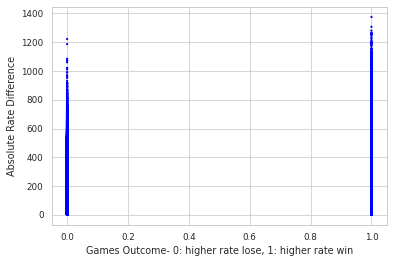

In [44]:
plt.scatter(df_fnl_modified['Higher_Rated_Plyr_Win'], df_fnl_modified['Diff_Rating'] ,color='blue',s=5,edgecolor='none')
plt.xlabel('Games Outcome- 0: higher rate lose, 1: higher rate win')
plt.ylabel('Absolute Rate Difference')
plt.show()

In [45]:
# Split Dataframes -  HighRatedPlayer & LowRatedPlayer

hpw = df_fnl_modified.loc[df_fnl_modified['Higher_Rated_Plyr_Win'] == 1]
hpw_cnt = hpw[hpw.columns[1]].count() 
print("High Rated Player Win Count", hpw_cnt)

lpw = df_fnl_modified.loc[df_fnl_modified['Higher_Rated_Plyr_Win'] == 0]
lpw_cnt = lpw[lpw.columns[1]].count() 
print("Low Rated Player Win Count", lpw_cnt)

High Rated Player Win Count 2155105
Low Rated Player Win Count 1104549


In [46]:
# Calculating the Total Record count from the DataFrame

tot_cnt = df_fnl_modified.shape[0]
tot_cnt

3259654

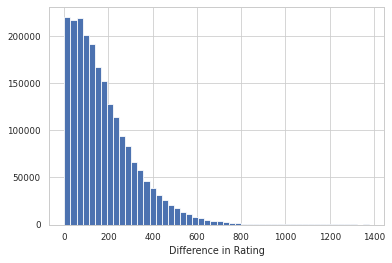

In [47]:
# Plotting Histogram when the High Rated Player Wins

plt.hist(hpw["Diff_Rating"], bins=50)
plt.xlabel ("Difference in Rating")
plt.show()


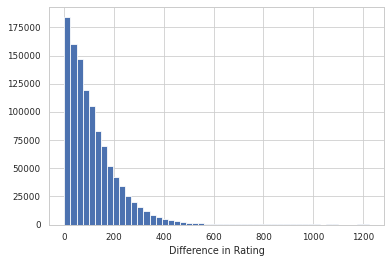

In [48]:
# Plotting Histogram when the Low Rated Player Wins

plt.hist(lpw["Diff_Rating"], bins=50)
plt.xlabel ("Difference in Rating")
plt.show()

In [49]:
# Calculating the probability of player with higher rank winning the game

probability_higher_rating_win = hpw_cnt / df_fnl_modified.shape[0]
probability_higher_rating_win

0.6611453240129167

Based on the above data, we can infer that in 66% of the games, the player with higher rating has won the game which is almost double the cases, when player with lower rank won the game (34%). 

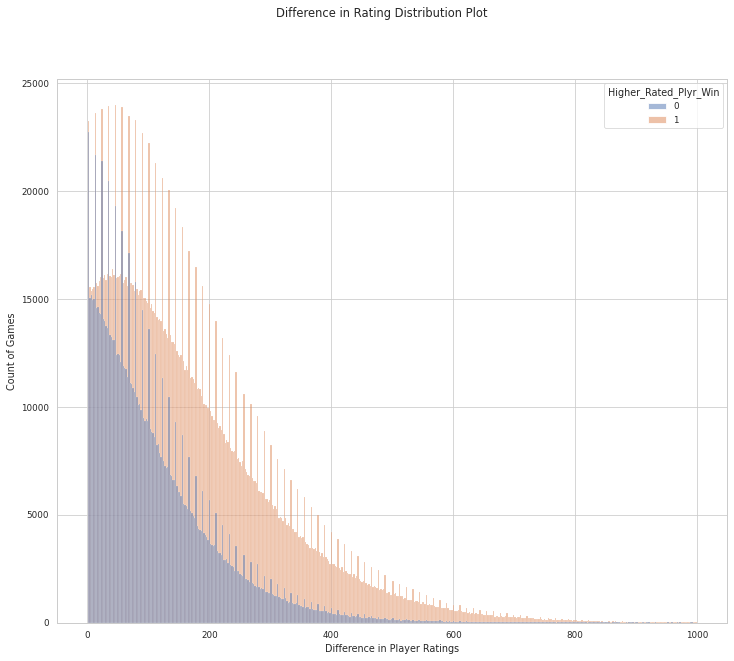

In [50]:
# Modify dataframe to only include rows where difference in rating is less than 1000

df_diffrtglt1k = df_fnl_modified.loc[df_fnl_modified['Diff_Rating'] < 1000]
#print(df_diffrtglt900)

# Difference in Rating distribution Grouped by High_Rated_Player_Win

chart = plt.figure(figsize=(12,10))
ax = sns.histplot(data=df_diffrtglt1k ,x='Diff_Rating',hue='Higher_Rated_Plyr_Win' )
ax.set_xlabel("Difference in Player Ratings")
ax.set_ylabel("Count of Games")

chart.suptitle('Difference in Rating Distribution Plot')

#fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 6), sharey=False)
#fig.tight_layout()
plt.show()

Based on the above graph, it is evident that as the Difference in Rating between the players increase, the Higher Rated Player wins more number of games than the lower rated player. And from the computation of probability_higher_rating_win column, the probability is 66% which is ~2x times than the probability of win of a lower rated player

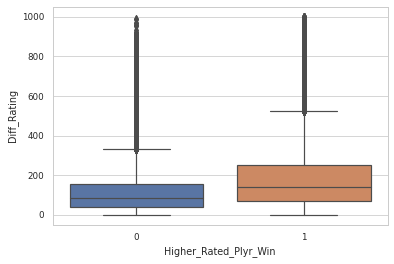

In [51]:
# Box Plots

sns.boxplot(data = df_diffrtglt1k,           
            x='Higher_Rated_Plyr_Win', y='Diff_Rating'
            #,hue="stops", ax=ax1
           )
plt.show()
#ax1.title.set_text('Class = Economy')

Atie - we can see above that the mean difference in ratings when the higher ranked player wins is much higher than when they lose which implies the fact that when the difference in the players level of profission increases, the higher ranked player is more likely to win. 

# Hypothesis 3 #

In [52]:
df_fnl.head()

,WhiteElo,BlackElo,Winner,Termination,TimeControl,Number_of_Moves,Win_Color,Rating,TimeControl_Blitz,TimeControl_Bullet,TimeControl_Classical,TimeControl_Rapid,Term_Rul_Normal,Term_Rul_Infraction,Term_Rul_Time_Forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,1516,1480,White,Time forfeit,Bullet,28,1,W,0,1,0,0,0,0,1,0,0,1,36,1
1,1231,1814,Black,Normal,Bullet,19,0,B,0,1,0,0,1,0,0,1,0,0,583,1
2,1612,1555,Black,Normal,Bullet,13,0,W,0,1,0,0,1,0,0,0,0,1,57,0
3,1879,1237,White,Time forfeit,Bullet,21,1,W,0,1,0,0,0,0,1,0,0,1,642,1
4,1815,1222,White,Time forfeit,Bullet,33,1,W,0,1,0,0,0,0,1,0,0,1,593,1


In [53]:
df_gt = df_fnl.loc[df_fnl['TimeControl'] == 'Bullet']

In [54]:
df_gt.head(10)

,WhiteElo,BlackElo,Winner,Termination,TimeControl,Number_of_Moves,Win_Color,Rating,TimeControl_Blitz,TimeControl_Bullet,TimeControl_Classical,TimeControl_Rapid,Term_Rul_Normal,Term_Rul_Infraction,Term_Rul_Time_Forfeit,Rating_B,Rating_EQ,Rating_W,Diff_Rating,Higher_Rated_Plyr_Win
0,1516,1480,White,Time forfeit,Bullet,28,1,W,0,1,0,0,0,0,1,0,0,1,36,1
1,1231,1814,Black,Normal,Bullet,19,0,B,0,1,0,0,1,0,0,1,0,0,583,1
2,1612,1555,Black,Normal,Bullet,13,0,W,0,1,0,0,1,0,0,0,0,1,57,0
3,1879,1237,White,Time forfeit,Bullet,21,1,W,0,1,0,0,0,0,1,0,0,1,642,1
4,1815,1222,White,Time forfeit,Bullet,33,1,W,0,1,0,0,0,0,1,0,0,1,593,1
5,1877,1319,White,Normal,Bullet,20,1,W,0,1,0,0,1,0,0,0,0,1,558,1
6,1367,1555,Black,Time forfeit,Bullet,10,0,B,0,1,0,0,0,0,1,1,0,0,188,1
10,1214,1816,Black,Time forfeit,Bullet,31,0,B,0,1,0,0,0,0,1,1,0,0,602,1
11,1878,1243,White,Time forfeit,Bullet,21,1,W,0,1,0,0,0,0,1,0,0,1,635,1
12,1600,1863,Black,Normal,Bullet,36,0,B,0,1,0,0,1,0,0,1,0,0,263,1


In [55]:
df_gt.dtypes

WhiteElo                  int64
BlackElo                  int64
Winner                   object
Termination              object
TimeControl              object
Number_of_Moves           int64
Win_Color                object
Rating                   object
TimeControl_Blitz         uint8
TimeControl_Bullet        uint8
TimeControl_Classical     uint8
TimeControl_Rapid         uint8
Term_Rul_Normal           uint8
Term_Rul_Infraction       uint8
Term_Rul_Time_Forfeit     uint8
Rating_B                  uint8
Rating_EQ                 uint8
Rating_W                  uint8
Diff_Rating               int64
Higher_Rated_Plyr_Win    object
dtype: object

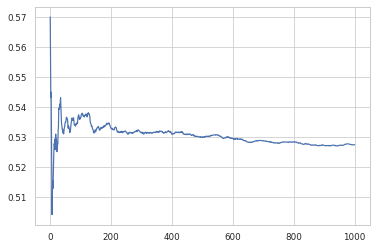

In [56]:
# Random Sampling

samplesize = 100
whitewin = 0
x_data = []
y_data = []

for num_simulations in range(1, 1001):
    df_gt_sample = df_gt.sample(n=samplesize)
    whitewin += len(df_gt_sample[df_gt_sample.Win_Color == 1])
    y_data.append(float(whitewin) / float(num_simulations*samplesize))
    x_data.append(num_simulations)

plt.plot(x_data,y_data)

Based on the above plot, the probability of white winning in any game (less < 3 mins, Gametype == Bullet was used for the purpose of this illustration) is about 0.53. Though this is slightly higher than the ideal mean of 0.5, but it is not strong enough to indicate a bias towards white for any game.

In [58]:
samplesize_gt = len(df_gt_sample.index)
#whitewin_gt = len(df_gt_sample[df_gt_sample.Win_Color == 1])
#pointestimate_gt = whitewin_gt/samplesize_gt
pointestimate_gt = y_data[num_simulations-1]
print ("pointestimate:", pointestimate_gt)
#p for null hypothesis
po_gt = 0.5
#standard error for null hypothesis
SEo_gt = np.sqrt(((po_gt*(1-po_gt))/samplesize_gt))
print ("Standard Error:", SEo_gt)

sigma_gt = SEo_gt * np.sqrt(samplesize_gt)
print ("Sigma:", sigma_gt)

z = (pointestimate_gt - po_gt)/SEo_gt
print ("Z Value:", z)

#right vs left
pnew_gt = 2*norm.sf(abs(z))

print ("New P-value", pnew_gt)

pointestimate: 0.52757
Standard Error: 0.05
Sigma: 0.5
Z Value: 0.5513999999999997
New P-value 0.5813595006947428


In [59]:
if pnew_gt <= 0.05:
    print("The new p-value is less than 0.05 and hence the NULL hypothesis can be rejected with 95% confidence. The probability of winning is not equal for both white and black")
else:
    print("The new p-value is greater than 0.05 and hence the NULL hypothesis cannot be rejected. There is no strong evidence to reject that winning is equal for both white and black")
    

The new p-value is greater than 0.05 and hence the NULL hypothesis cannot be rejected. There is no strong evidence to reject that winning is equal for both white and black


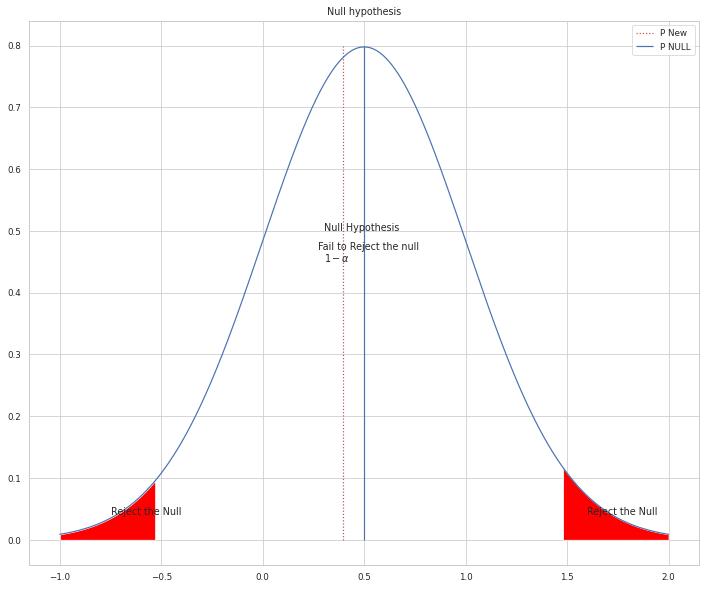

In [60]:
plt.figure(figsize=(12,10))

#find the value where the 95% confidence level starts
x_cr = norm.ppf(0.025, loc=po_gt, scale=sigma_gt)
x_r = (po_gt - x_cr) + po_gt

start = po_gt-3*(sigma_gt)
end = po_gt+3*(sigma_gt)
if po_gt < pointestimate_gt:
    pnew_gt = 1 - pnew_gt

x = np.linspace(start, end, 1000)
plt.plot(x, norm.pdf(x, loc=po_gt, scale=sigma_gt))
plt.title("Null hypothesis")
plt.fill_between(x=np.arange(start, (start + abs(x_cr)), 0.01), y1=norm.pdf(np.arange(start, (start + abs(x_cr)), 0.01), loc=po_gt, scale=sigma_gt),
                 facecolor='red')
plt.fill_between(x=np.arange(x_r,end, 0.01), y1= norm.pdf(np.arange(x_r, end,0.01), loc=po_gt, scale=sigma_gt) ,
                 facecolor='red')

plt.text(x=0.30, y=0.5, s= "Null Hypothesis")
plt.text(x=0.27, y=0.47, s= 'Fail to Reject the null')
plt.text(x=0.30, y=0.45, s=r'$1- \alpha$')
plt.text(x=-0.75, y=0.04, s= "Reject the Null")
plt.text(x=1.6, y=0.04, s= "Reject the Null")

plt.vlines(norm.ppf(pnew_gt, loc=po_gt, scale=sigma_gt), 0, 0.8, colors='r', linestyles='dotted', label='P New')
plt.vlines(po_gt, 0, 0.8, colors='b', linestyles='solid', label='P NULL')

plt.legend(loc="upper right")

# Predictive Model #

## Logistic Regression ##

### Feature Selection - Split Predictor and Response variables ###

In [61]:
# Separating the predictor and response variables
#predictors = data_fnl_md[['Number_of_Moves', 'TimeControl_Bullet','TimeControl_Classical','TimeControl_Rapid','Term_Rul_Infraction', 'Term_Rul_Forfeit', 'Rating_B', 'Rating_EQ', 'Rating_W']]
pred_var = ['Number_of_Moves', 'Diff_Rating','TimeControl_Blitz', 'TimeControl_Bullet', 'TimeControl_Classical', 'TimeControl_Rapid', 'Term_Rul_Normal', 'Term_Rul_Infraction','Term_Rul_Time_Forfeit','Rating_B','Rating_EQ', 'Rating_W']
resp_var = ['Win_Color']

### Fitting the entire dataset using the Logit link Function ###

In [62]:
# Fitting the Model
m = Logit(df_fnl[resp_var].astype(float) ,df_fnl[pred_var].astype(float))
m = m.fit()

         Current function value: 0.638950
         Iterations: 35


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
m.params

Number_of_Moves          -0.003708
Diff_Rating               0.000068
TimeControl_Blitz         1.483603
TimeControl_Bullet        1.467847
TimeControl_Classical     1.414159
TimeControl_Rapid         1.455898
Term_Rul_Normal          -3.183873
Term_Rul_Infraction      12.180858
Term_Rul_Time_Forfeit    -3.175505
Rating_B                  1.256436
Rating_EQ                 1.978603
Rating_W                  2.586465
dtype: float64

In [64]:
print(m.summary2())

                                Results: Logit
Model:                  Logit                Pseudo R-squared:     0.076       
Dependent Variable:     Win_Color            AIC:                  4177883.4285
Date:                   2022-12-12 23:50     BIC:                  4178013.4295
No. Observations:       3269322              Log-Likelihood:       -2.0889e+06 
Df Model:               9                    LL-Null:              -2.2609e+06 
Df Residuals:           3269312              LLR p-value:          0.0000      
Converged:              0.0000               Scale:                1.0000      
No. Iterations:         35.0000                                                
-------------------------------------------------------------------------------
                       Coef.   Std.Err.     z     P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------
Number_of_Moves       -0.0037     0.0001 -48.1434 0.0000     -0.0039    -

As it can be inferred from the summary statistics, "*Term_Rul_*" variables have an extremely high p value which indicates that this feature is not significant to the response variable. Therefore, this variable has to be removed.

Re-run the model after removing this variable

## Logistic Regression using sklearn ##

### Feature Selection - Split Predictor and Response variables ###

In [65]:
# Creating Predictor and Response variables after removing Term_Rul variables from the list of predictors #

pred_var_2 = ['Number_of_Moves', 'Diff_Rating','TimeControl_Blitz', 'TimeControl_Bullet', 'TimeControl_Classical', 'TimeControl_Rapid','Rating_B','Rating_EQ', 'Rating_W']
resp_var_2 = ['Win_Color']

### Train Test Split ###

In [66]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_fnl[pred_var_2],df_fnl[resp_var_2], test_size = 0.30, random_state=0)

### Feature Scaling ###

In [67]:
from sklearn.preprocessing import  StandardScaler
sc = StandardScaler()
X_train_2_scaled = sc.fit_transform(X_train_2)
X_test_2_scaled = sc.transform(X_test_2)

In [68]:
# Transforming the response variable from an object to an int datatype before passing it into the model

y_train_2=y_train_2.astype('int')
y_test_2=y_test_2.astype('int')

In [69]:
print("Number of rows in Training Dataset" , X_train_2.shape[0])
print("Number of cols in Training Dataset" , X_train_2.shape[1])
print("Number of response cols in Training Dataset" , y_train_2.shape[1])
print("Number of rows in Test Dataset" , X_test_2.shape[0])
print("Number of cols in Test Dataset" , X_test_2.shape[1])
print("Number of response cols in Test Dataset" , y_train_2.shape[1])

Number of rows in Training Dataset 2288525
Number of cols in Training Dataset 9
Number of response cols in Training Dataset 1
Number of rows in Test Dataset 980797
Number of cols in Test Dataset 9
Number of response cols in Test Dataset 1


### Model Fitting and Prediction using the sklearn package ###

In [70]:
# Fitting the Model

from sklearn.linear_model import LogisticRegression
log_reg_m2 = LogisticRegression(random_state=0)
log_reg_m2.fit(X_train_2_scaled, y_train_2)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [71]:
log_reg_m2

LogisticRegression(random_state=0)

In [72]:
# Prediction based on Training dataset

log_reg_m2.predict(X_train_2_scaled)

array([1, 0, 0, ..., 0, 1, 0])

In [73]:
# Prediction based on Testing dataset

y_pred_2 = log_reg_m2.predict(X_test_2_scaled)

### Model Evaluation ###

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64    462721
           1       0.68      0.67      0.68    518076

    accuracy                           0.66    980797
   macro avg       0.66      0.66      0.66    980797
weighted avg       0.66      0.66      0.66    980797



In [75]:
# Accuracy Score in %

from sklearn.metrics import accuracy_score
round(accuracy_score(y_test_2, y_pred_2) *100,2)

66.04

In [76]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_2, y_pred_2)
cm

array([[299283, 163438],
       [169612, 348464]])

Text(68.7, 0.5, 'Truth')

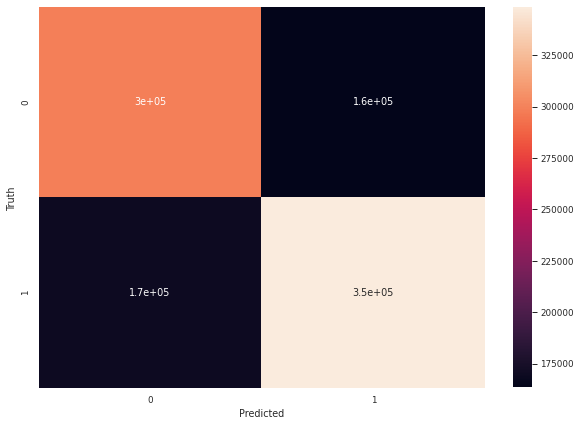

In [77]:
# Visualizing the confusion matrix

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [78]:
# Computing the TP, FP, FN, TP

tn, fp, fn, tp = cm.flatten()
print(tn,fp, fn, tp)

299283 163438 169612 348464


In [79]:
# Compute Model Precision, Recall & Specificity

# Precision
prc = tp / (tp + fp)

# Recall or TPR (True Positive Rate) or Sensitivity
rec = tp / (tp + fn)

spec = tn / (tn + fp) 
print ("Model's precision is %1.2f ; Recall / TPR / Sensitivity is %1.2f ; Specificity is %1.2f" %  (prc, rec, spec))

Model's precision is 0.68 ; Recall / TPR / Sensitivity is 0.67 ; Specificity is 0.65


In [80]:
# ROC Curve

from sklearn.metrics import roc_auc_score as auc
print(auc(y_test_2, y_pred_2))

0.6597005291657806


In [81]:
# F1 Score

# F-1 Score or Harmonic Mean
f1 = (
    (2. * rec * prc) /
    (rec + prc))

print ("Model's F1 Score is %1.2f" %  (f1))

Model's F1 Score is 0.68


As we can see, both the techniques give us a good accuracy score of 66% with a F1 Score of 68% , whoch means that the model is able to predict the Winner of the game with a reasonable accuracy.

**Game Outcome ** 

1 - White wins the game
0 - Black wins the game or White Loses the Game